Using device: cuda
SVM Average Accuracy: 0.9282
Logistic Regression Average Accuracy: 0.9377
SVM Average F1-Score: 0.9264
Logistic Regression Average F1-Score: 0.9366

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1263
           1       0.88      0.99      0.93      1263
           2       0.99      0.80      0.88      1263

    accuracy                           0.93      3789
   macro avg       0.93      0.93      0.93      3789
weighted avg       0.93      0.93      0.93      3789


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1263
           1       0.90      0.98      0.94      1263
           2       0.98      0.84      0.90      1263

    accuracy                           0.94      3789
   macro avg       0.94      0.94      0.94      3789
weighted avg       0.94      0.94      0.94      378

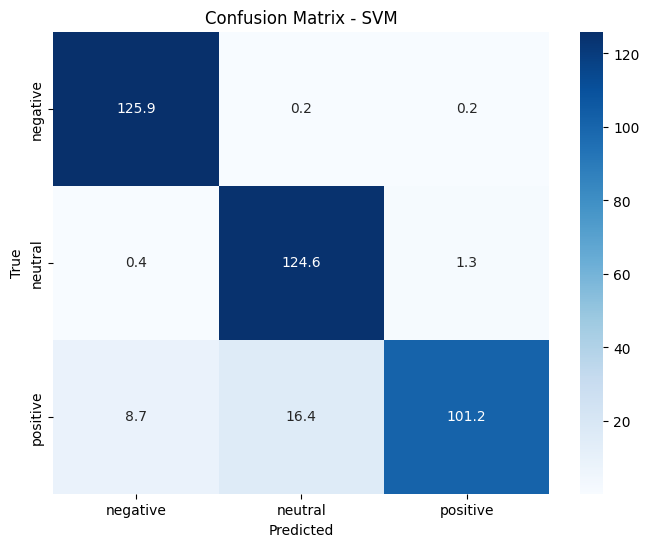

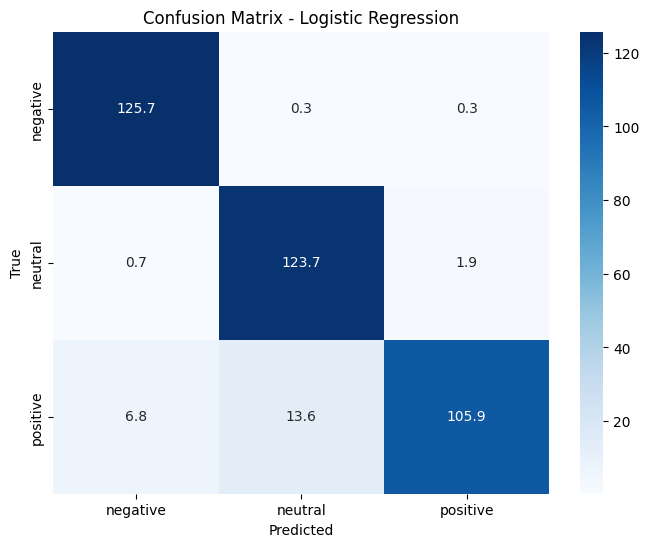


SVM F1-score for class negative: 0.9636
Logistic Regression F1-score for class negative: 0.9688

SVM F1-score for class neutral: 0.9316
Logistic Regression F1-score for class neutral: 0.9375

SVM F1-score for class positive: 0.8838
Logistic Regression F1-score for class positive: 0.9036


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 1. Google Colab'da GPU kullanımını kontrol etme
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Veri yükleme
def load_data(file_path):
    """Veriyi yükler ve döndürür"""
    data = pd.read_csv(file_path)
    return data

# Veri ön işleme: Vektörize etme ve label encoding
def preprocess_data(data):
    """Yorumları vektörize eder ve etiketleri sayısal hale getirir"""
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(data['Lemmatized_Comment'])

    encoder = LabelEncoder()
    y = encoder.fit_transform(data['Label'])

    return X, y, vectorizer, encoder

# Eğitim ve test verisine ayırma
def split_data(X, y):
    """Veriyi eğitim ve test olarak böler"""
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE ile veri dengeleme
def apply_smote(X_train, y_train):
    """SMOTE ile veri setini dengele"""
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

# K-Fold Cross Validation fonksiyonu
def train_evaluate_models(X_train_resampled, y_train_resampled):
    """Modelleri eğitim ve test verisi ile eğitir ve değerlendirir"""
    svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='linear', C=1, gamma='scale'))
    log_reg_model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000, C=1, solver='liblinear'))

    svm_accuracies, log_reg_accuracies = [], []
    svm_f1_scores, log_reg_f1_scores = [], []
    svm_conf_matrix, log_reg_conf_matrix = [], []
    svm_predictions_all, log_reg_predictions_all, y_test_all = [], [], []

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # K-Fold çapraz doğrulama ile her iki modelin eğitim ve test edilmesi
    for train_index, test_index in kf.split(X_train_resampled, y_train_resampled):
        X_train_fold, X_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
        y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]

        # SVM modelini eğitelim
        svm_model.fit(X_train_fold, y_train_fold)
        svm_predictions = svm_model.predict(X_test_fold)

        # Lojistik Regresyon modelini eğitelim
        log_reg_model.fit(X_train_fold, y_train_fold)
        log_reg_predictions = log_reg_model.predict(X_test_fold)

        # Performans metriklerini hesaplayalım
        svm_accuracies.append(accuracy_score(y_test_fold, svm_predictions))
        log_reg_accuracies.append(accuracy_score(y_test_fold, log_reg_predictions))

        svm_f1_scores.append(f1_score(y_test_fold, svm_predictions, average='macro'))
        log_reg_f1_scores.append(f1_score(y_test_fold, log_reg_predictions, average='macro'))

        # Confusion matrix
        svm_conf_matrix.append(confusion_matrix(y_test_fold, svm_predictions))
        log_reg_conf_matrix.append(confusion_matrix(y_test_fold, log_reg_predictions))

        # Tahminleri ve gerçek etiketleri saklayalım
        svm_predictions_all.extend(svm_predictions)
        log_reg_predictions_all.extend(log_reg_predictions)
        y_test_all.extend(y_test_fold)

    return svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_conf_matrix, log_reg_conf_matrix, svm_predictions_all, log_reg_predictions_all, y_test_all

# Performans metriklerini yazdırma
def print_performance_metrics(svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_predictions_all, log_reg_predictions_all, y_test_all):
    """Ortalama metrikleri ve classification report'ları yazdırır"""
    svm_avg_accuracy = sum(svm_accuracies)/len(svm_accuracies)
    log_reg_avg_accuracy = sum(log_reg_accuracies)/len(log_reg_accuracies)
    svm_avg_f1 = sum(svm_f1_scores)/len(svm_f1_scores)
    log_reg_avg_f1 = sum(log_reg_f1_scores)/len(log_reg_f1_scores)

    print(f"SVM Average Accuracy: {svm_avg_accuracy:.4f}")
    print(f"Logistic Regression Average Accuracy: {log_reg_avg_accuracy:.4f}")
    print(f"SVM Average F1-Score: {svm_avg_f1:.4f}")
    print(f"Logistic Regression Average F1-Score: {log_reg_avg_f1:.4f}")

    # Classification Report ve Macro-Averaged Scores
    print("\nSVM Classification Report:\n", classification_report(y_test_all, svm_predictions_all))
    print("\nLogistic Regression Classification Report:\n", classification_report(y_test_all, log_reg_predictions_all))

    # Macro-averaged metrics
    svm_macro_avg_recall = sum([report['macro avg']['recall'] for report in svm_class_reports])/len(svm_class_reports)
    log_reg_macro_avg_recall = sum([report['macro avg']['recall'] for report in log_reg_class_reports])/len(log_reg_class_reports)

    svm_macro_avg_precision = sum([report['macro avg']['precision'] for report in svm_class_reports])/len(svm_class_reports)
    log_reg_macro_avg_precision = sum([report['macro avg']['precision'] for report in log_reg_class_reports])/len(log_reg_class_reports)

    svm_macro_avg_f1 = sum([report['macro avg']['f1-score'] for report in svm_class_reports])/len(svm_class_reports)
    log_reg_macro_avg_f1 = sum([report['macro avg']['f1-score'] for report in log_reg_class_reports])/len(log_reg_class_reports)

    print(f"\nSVM Macro-Averaged Recall: {svm_macro_avg_recall:.4f}")
    print(f"Logistic Regression Macro-Averaged Recall: {log_reg_macro_avg_recall:.4f}")
    print(f"SVM Macro-Averaged Precision: {svm_macro_avg_precision:.4f}")
    print(f"Logistic Regression Macro-Averaged Precision: {log_reg_macro_avg_precision:.4f}")
    print(f"SVM Macro-Averaged F1-Score: {svm_macro_avg_f1:.4f}")
    print(f"Logistic Regression Macro-Averaged F1-Score: {log_reg_macro_avg_f1:.4f}")

# Confusion matrix görselleştirme
def plot_confusion_matrix(cm, model_name, encoder):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# F1-Score her sınıf için yazdırma
def print_class_f1_scores(svm_predictions_all, log_reg_predictions_all, y_test_all, encoder):
    for i, label in enumerate(encoder.classes_):
        svm_class_f1_scores = f1_score(y_test_all, svm_predictions_all, labels=[i], average='macro')
        log_reg_class_f1_scores = f1_score(y_test_all, log_reg_predictions_all, labels=[i], average='macro')
        print(f"\nSVM F1-score for class {label}: {svm_class_f1_scores:.4f}")
        print(f"Logistic Regression F1-score for class {label}: {log_reg_class_f1_scores:.4f}")

# Ana fonksiyon
def main(file_path):
    data = load_data(file_path)
    X, y, vectorizer, encoder = preprocess_data(data)
    X_train, X_test, y_train, y_test = split_data(X, y)
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_conf_matrix, log_reg_conf_matrix, svm_predictions_all, log_reg_predictions_all, y_test_all = train_evaluate_models(X_train_resampled, y_train_resampled)

    print_performance_metrics(svm_accuracies, log_reg_accuracies, svm_f1_scores, log_reg_f1_scores, svm_predictions_all, log_reg_predictions_all, y_test_all)

    svm_avg_conf_matrix = sum(svm_conf_matrix) / len(svm_conf_matrix)
    log_reg_avg_conf_matrix = sum(log_reg_conf_matrix) / len(log_reg_conf_matrix)

    plot_confusion_matrix(svm_avg_conf_matrix, "SVM", encoder)
    plot_confusion_matrix(log_reg_avg_conf_matrix, "Logistic Regression", encoder)

    print_class_f1_scores(svm_predictions_all, log_reg_predictions_all, y_test_all, encoder)

# Dosya yolunu burada belirtin
file_path = 'lemmatized_comments_with_labels.csv'
main(file_path)


In [ ]:
#ZERO-SHOT

In [7]:
pip install transformers


In [8]:
import pandas as pd
from transformers import pipeline
import torch

# 1. Google Colab'da GPU kullanımını kontrol etme
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Veri setini yükleyelim
file_path = 'lemmatized_comments_with_labels.csv'  # Yüklediğiniz dosyanın yolu
data = pd.read_csv(file_path)

# 3. Zero-shot sentiment analysis için Hugging Face pipeline'ı yükleyelim
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if torch.cuda.is_available() else -1)

# 4. Zero-shot sentiment analysis fonksiyonu
def zero_shot_sentiment_analysis(texts, candidate_labels=["positive", "neutral", "negative"]):
    """
    Zero-shot sentiment analysis yapar.
    texts: İncelenecek metinler listesi.
    candidate_labels: Sınıflandırılacak etiketler (default: positive, negative, neutral).
    """
    results = []
    for text in texts:
        result = classifier(text, candidate_labels)
        results.append(result)
    return results

# 5. Metinleri analiz etme
def apply_zero_shot_analysis(X_test, labels=["positive", "neutral", "negative"]):
    """Test setindeki veriler için zero-shot sentiment analizi uygular"""
    texts = X_test
    results = zero_shot_sentiment_analysis(texts, candidate_labels=labels)

    return results

# 6. Veri setinden metinleri alalım (label kullanmıyoruz)
X_test = data['Lemmatized_Comment'].tolist()

# 7. Zero-Shot Sentiment Analysis uygulama
zero_shot_results = apply_zero_shot_analysis(X_test, labels=["positive", "neutral", "negative"])

# 8. İlk 5 sonucu yazdıralım
for i, result in enumerate(zero_shot_results[:5]):
    print(f"Text: {X_test[i]}")
    print(f"Predicted Label: {result['labels'][0]}, Score: {result['scores'][0]}")
    print("-" * 50)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Text: update video form
Predicted Label: positive, Score: 0.4502250552177429
--------------------------------------------------
Text: call name cum peach walked parasite killer peach could run
Predicted Label: negative, Score: 0.6301938891410828
--------------------------------------------------
Text: another bong hit
Predicted Label: negative, Score: 0.3801746368408203
--------------------------------------------------
Text: expectation high holy fuck
Predicted Label: positive, Score: 0.5434213280677795
--------------------------------------------------
Text: question people rate 45 want literally want
Predicted Label: positive, Score: 0.41330236196517944
--------------------------------------------------


In [10]:
import torch
from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the dataset
file_path = 'lemmatized_comments_with_labels.csv'
df = pd.read_csv(file_path)

# Use the Lemmatized_Comment for prediction
comments = df['Lemmatized_Comment'].tolist()

# Check if CUDA (GPU) is available and set the device accordingly
device = 0 if torch.cuda.is_available() else -1  # -1 means using CPU, 0 means using GPU

# Load a zero-shot classifier model (using Hugging Face's pipeline)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)  # Use GPU if available

# Define possible labels
labels = ['positive', 'neutral', 'negative']

# Run zero-shot classification on the comments
results = []
for comment in comments:
    result = classifier(comment, candidate_labels=labels)
    results.append(result['labels'][0])  # Get the label with the highest score

# Add the predictions to the dataframe
df['Predicted_Label'] = results

# Calculate performance metrics
accuracy = accuracy_score(df['Label'], df['Predicted_Label'])
precision, recall, f1, _ = precision_recall_fscore_support(df['Label'], df['Predicted_Label'], labels=['positive', 'neutral', 'negative'], average='weighted')

# Save the dataframe with the predictions to a new CSV file
output_file = 'lemmatized_comments_with_predictions.csv'
df.to_csv(output_file, index=False)

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Provide the output file path
output_file


Device set to use cuda:0


Accuracy: 0.5436
Precision: 0.6214
Recall: 0.5436
F1-score: 0.5251


'lemmatized_comments_with_predictions.csv'